# Anomaly detection 

## 1.Introduction

In this notebook, there are four sections
The goal is to predict and prevent anomalies in SKAB data.

### SKAB Dataset (Skoltech Anomaly Benchmark)

Industrial testbed simulating a water circulation system with a pump and sensors.

##### Sensors (8)

| Sensor | Measures |
|--------|----------|
| Accelerometer1RMS | Vibration |
| Accelerometer2RMS | Vibration |
| Current | Motor |
| Voltage | Motor |
| Temperature | Heat |
| Thermocouple | Heat |
| Pressure | Flow pressure |
| Volume Flow RateRMS | Water flow |

##### Anomaly types

- **valve1/** → valve closing at pump inlet (16 experiments)
- **valve2/** → valve closing at pump outlet (4 experiments)
- **other/** → rotor imbalance, leaks, cavitation, temperature changes (14 experiments)
- **anomaly-free/** → normal operation (baseline)

#### Labels

- `anomaly` → 1 if anomaly active, 0 if normal
- `changepoint` → 1 at the exact moment anomaly starts

#### Sampling

1 Hz (1 row per second)
Sampling: 1 Hz (1 row per second)

#### Workflow 

1. **Preprocessing & Feature Engineering** → clean data, combine files, create features
2. **Changepoint Detection** → detect when anomaly starts (PELT), CUMSUM
3. **Anomaly Detection** → confirm and score anomalies (Z-score, Isolation Forest)
4. TBD **Time-to-Anomaly Prediction** → predict when next anomaly occurs (Cox model) 

## 2 . Load and preprocess data + quick EDA


In [2]:
# import & combine data in one file
import polars as pl
from pathlib import Path

skab_path = Path("../data/raw_for_notebook/SKAB/data")
all_files = list(skab_path.glob("**/*.csv"))

dfs = []
for file in all_files:
    df = pl.read_csv(file, separator=";")
    df = df.with_columns(pl.lit(file.parent.name).alias("experiment_type"))
    dfs.append(df)

data = pl.concat(dfs, how="diagonal").sort("datetime")

print(f"Rows: {len(data)}")
print(f"Anomalies: {data['anomaly'].sum()}")

with pl.Config(tbl_cols=-1, tbl_width_chars=180):
    print(data.head(5))

Rows: 46806
Anomalies: 13067.0
shape: (5, 12)
┌────────────┬───────────────────┬───────────────────┬─────────┬───────────┬─────────────┬──────────────┬─────────┬─────────────┬─────────┬─────────────┬─────────────────┐
│ datetime   ┆ Accelerometer1RMS ┆ Accelerometer2RMS ┆ Current ┆ Pressure  ┆ Temperature ┆ Thermocouple ┆ Voltage ┆ Volume Flow ┆ anomaly ┆ changepoint ┆ experiment_type │
│ ---        ┆ ---               ┆ ---               ┆ ---     ┆ ---       ┆ ---         ┆ ---          ┆ ---     ┆ RateRMS     ┆ ---     ┆ ---         ┆ ---             │
│ str        ┆ f64               ┆ f64               ┆ f64     ┆ f64       ┆ f64         ┆ f64          ┆ f64     ┆ ---         ┆ f64     ┆ f64         ┆ str             │
│            ┆                   ┆                   ┆         ┆           ┆             ┆              ┆         ┆ f64         ┆         ┆             ┆                 │
╞════════════╪═══════════════════╪═══════════════════╪═════════╪═══════════╪═════════════╪════

(46806, 12)
shape: (9, 13)
┌────────────┬───────────────┬───────────────┬──────────────┬──────────┬──────────┬─────────────┬──────────────┬────────────┬──────────────┬──────────┬─────────────┬──────────────┐
│ statistic  ┆ datetime      ┆ Accelerometer ┆ Acceleromete ┆ Current  ┆ Pressure ┆ Temperature ┆ Thermocouple ┆ Voltage    ┆ Volume Flow  ┆ anomaly  ┆ changepoint ┆ experiment_t │
│ ---        ┆ ---           ┆ 1RMS          ┆ r2RMS        ┆ ---      ┆ ---      ┆ ---         ┆ ---          ┆ ---        ┆ RateRMS      ┆ ---      ┆ ---         ┆ ype          │
│ str        ┆ str           ┆ ---           ┆ ---          ┆ f64      ┆ f64      ┆ f64         ┆ f64          ┆ f64        ┆ ---          ┆ f64      ┆ f64         ┆ ---          │
│            ┆               ┆ f64           ┆ f64          ┆          ┆          ┆             ┆              ┆            ┆ f64          ┆          ┆             ┆ str          │
╞════════════╪═══════════════╪═══════════════╪══════════════╪═══════

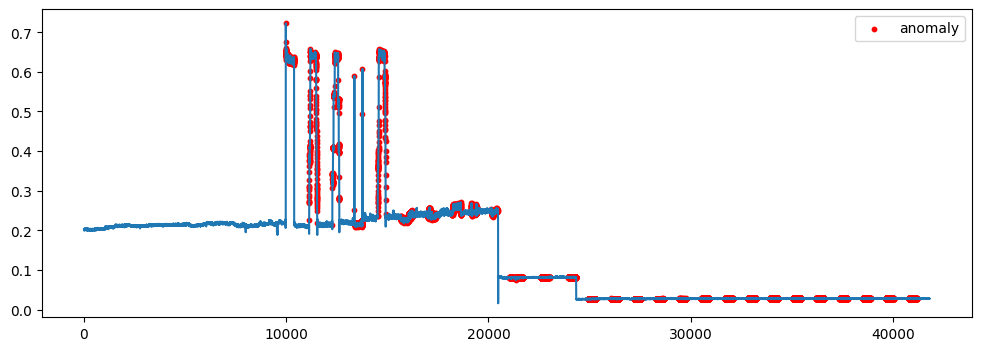

In [3]:
# Quick EDA :
# Shape of data
with pl.Config(tbl_cols=-1, tbl_width_chars=180):
    print(data.shape)
    print(data.describe())

    # Anomalies distribution
    print(data.group_by("experiment_type").agg(pl.col("anomaly").sum()).transpose())

# Quick viz of a sensor
import matplotlib.pyplot as plt

sample = data.head(-5000)
plt.figure(figsize=(12,4))
plt.plot(sample["Accelerometer1RMS"].to_numpy())
plt.scatter(
    sample.with_row_index().filter(pl.col("anomaly") == 1)["index"].to_numpy(),
    sample.filter(pl.col("anomaly") == 1)["Accelerometer1RMS"].to_numpy(),
    c='red', s=10, label='anomaly'
)
plt.legend()
plt.show()

In [74]:
data = data.fill_null(0)


Since this data is from kaggle and for the lack of time, and also since we already have labels we can use to evaluate the results. I will skip more EDA and feature engineering to focus on models.  

In case the models don't do well, some feature engineering will be necessary. 


## 3. Models

### 3.1 **PELT** : Change point detection 
PELT: Test toutes les coupure possibles, puis calcule la variance pour chaque coupure ( les écarts depuis la moyenne / la médiane selon L1 ou L2 )  
**L1** changement de médiane  
**L2** changement de moyenne   
**rbf** changement de distribution  



In [ ]:
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt


Note: Models tested on a sample of 5000 rows (index 10000-15000) for faster iteration.

In [151]:
data_sample = data[10000:15000]

In [152]:

signal = data_sample["Accelerometer1RMS"].to_numpy()

## PELT detection
algo = rpt.Pelt(model="l2").fit(signal)
pred_changepoints = algo.predict(pen=1)



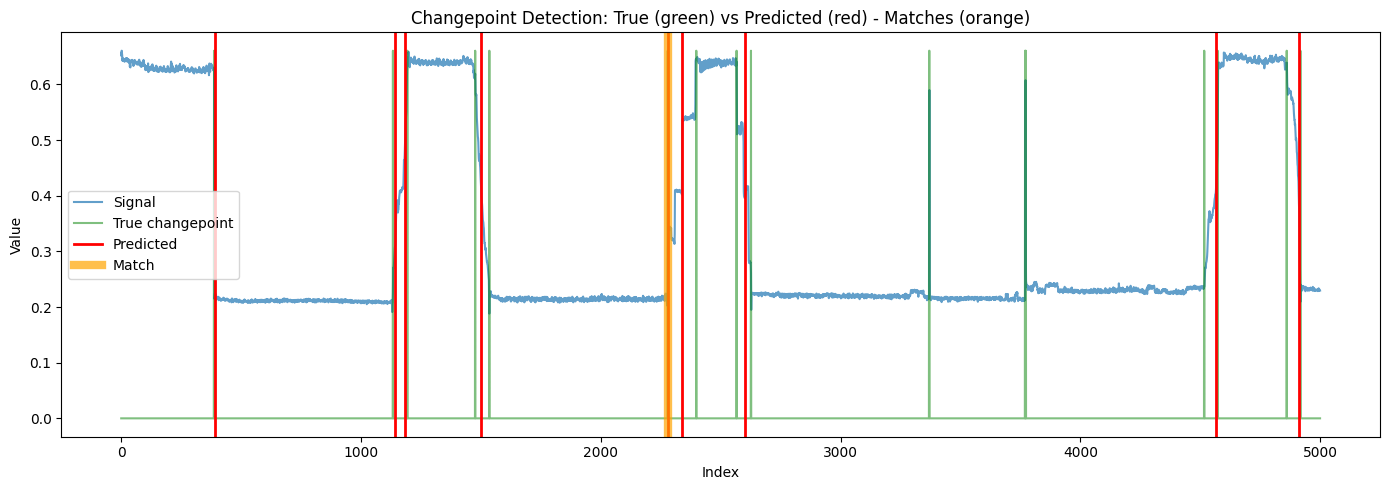

In [155]:
plt.figure(figsize=(14, 5))
plt.plot(signal, label="Signal", alpha=0.7)

# Scale changepoint to match signal range
cp_scaled = data_sample["changepoint"].to_numpy() * signal.max()
plt.plot(cp_scaled, color='green', label="True changepoint", alpha=0.5)

# Predicted changepoints (vertical red lines)
for i, idx in enumerate(pred_changepoints[:-1]):
    plt.axvline(x=idx, color="red", linestyle="-", linewidth=2,
                label="Predicted" if i == 0 else "")

# Matches (orange) - where predicted is close to true
tolerance = 2
true_cp_indices = np.where(data_sample["changepoint"].to_numpy() == 1)[0]
matched = False
for p_idx in pred_changepoints[:-1]:
    for t_idx in true_cp_indices:
        if abs(t_idx - p_idx) <= tolerance:
            plt.axvline(x=p_idx, color="orange", linestyle="-", linewidth=6, alpha=0.7,
                        label="Match" if not matched else "")
            matched = True
            break

plt.legend()
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Changepoint Detection: True (green) vs Predicted (red) - Matches (orange)")
plt.tight_layout()
plt.show()

### 3.2. **Z-score**: Anomaly Detection

Z-score: Combien d'écart type le point est loin de la moyenne.   
z-score robust : Combien d'écart type le point est loin de la médiane.  
On compare les deux, selon les données, ça se trouve que le bruit ne reflète pas des anomalies, et dans ce cas vaut mieux utiliser le z-score robuste. 

In [178]:
import numpy as np
from sklearn.metrics import classification_report, f1_score

# True labels
y_true = data_sample["anomaly"].to_numpy()

# Z-score classique
def zscore_anomaly(signal, threshold=3):
    mean = np.mean(signal)
    std = np.std(signal)
    zscore = np.abs((signal - mean) / std)
    return (zscore > threshold).astype(int)

# Robust Z-score
def robust_zscore_anomaly(signal, threshold=3):
    median = np.median(signal)
    mad = np.median(np.abs(signal - median))
    if mad == 0:
        mad = 1e-6
    zscore = np.abs((signal - median) / mad)
    return (zscore > threshold).astype(int)

# Test Classic Z-score with threshold=3 and threshold=1
y_pred_classic_3 = zscore_anomaly(signal, threshold=3)
y_pred_classic_1 = zscore_anomaly(signal, threshold=1)

# Test Robust Z-score with threshold=3
y_pred_robust = robust_zscore_anomaly(signal, threshold=3)

# Results
print("=== Classic Z-score (threshold=3) ===")
print(f"F1: {f1_score(y_true, y_pred_classic_3):.3f}")

print("\n=== Classic Z-score (threshold=1) ===")
print(f"F1: {f1_score(y_true, y_pred_classic_1):.3f}")

print("\n=== Robust Z-score (threshold=3) ===")
print(f"F1: {f1_score(y_true, y_pred_robust):.3f}")

# Summary table
print("\n=== Summary ===")
print(f"Classic (t=3): {f1_score(y_true, y_pred_classic_3):.3f}")
print(f"Classic (t=1): {f1_score(y_true, y_pred_classic_1):.3f}")
print(f"Robust  (t=3): {f1_score(y_true, y_pred_robust):.3f}")

=== Classic Z-score (threshold=3) ===
F1: 0.000

=== Classic Z-score (threshold=1) ===
F1: 0.792

=== Robust Z-score (threshold=3) ===
F1: 0.881

=== Summary ===
Classic (t=3): 0.000
Classic (t=1): 0.792
Robust  (t=3): 0.881


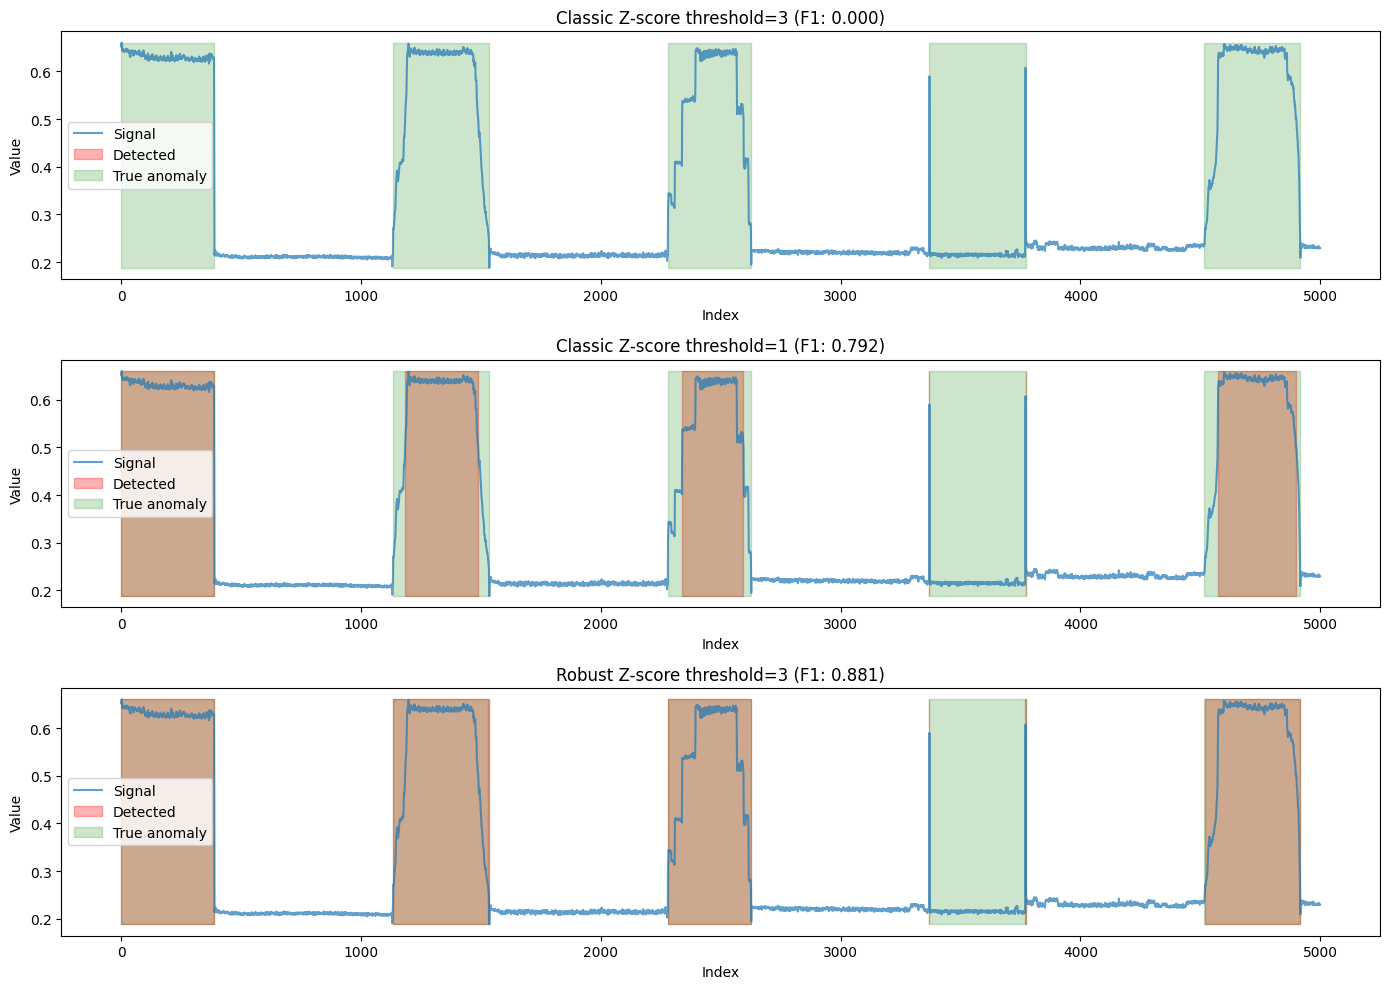

In [179]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Z-score Classic (threshold=3)
axes[0].plot(signal, label="Signal", alpha=0.7)
axes[0].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_pred_classic_3==1, color='red', alpha=0.3, label="Detected")
axes[0].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_true==1, color='green', alpha=0.2, label="True anomaly")
axes[0].set_title(f"Classic Z-score threshold=3 (F1: {f1_score(y_true, y_pred_classic_3):.3f})")
axes[0].legend()
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")

# Z-score Classic (threshold=1)
axes[1].plot(signal, label="Signal", alpha=0.7)
axes[1].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_pred_classic_1==1, color='red', alpha=0.3, label="Detected")
axes[1].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_true==1, color='green', alpha=0.2, label="True anomaly")
axes[1].set_title(f"Classic Z-score threshold=1 (F1: {f1_score(y_true, y_pred_classic_1):.3f})")
axes[1].legend()
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")

# Robust Z-score (threshold=3)
axes[2].plot(signal, label="Signal", alpha=0.7)
axes[2].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_pred_robust==1, color='red', alpha=0.3, label="Detected")
axes[2].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_true==1, color='green', alpha=0.2, label="True anomaly")
axes[2].set_title(f"Robust Z-score threshold=3 (F1: {f1_score(y_true, y_pred_robust):.3f})")
axes[2].legend()
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")

plt.tight_layout()
plt.show()

### 3.3 **Isolation Forest** for anomaly detection
This is the unsupervised decision tree based algorithm.  
The concept is that anomalies are separated early in the decision tree.  
For the isolation forest, anomalies are rare events that are isolated from the other data.  

We need three parameters: 
- n_estimators : number of trees  
- contamination : proportion expected of anomalies in the data  
- max_sample: number of samples to construct each tree.  

It doesn't need any hypothesis about data distribution, nor is complex to calculate, making it a good choice of unsupervised model.  
Limits: 
- n_estimator can impact the results significantly  
- anomalies near dense groups can go undetected  
- if anomalies are frequent, this method can fail te detect them.  


=== Isolation Forest (contamination=0.05) ===
F1: 0.227
              precision    recall  f1-score   support

      Normal       0.64      1.00      0.78      3060
     Anomaly       1.00      0.13      0.23      1940

    accuracy                           0.66      5000
   macro avg       0.82      0.56      0.51      5000
weighted avg       0.78      0.66      0.57      5000

=== Isolation Forest (contamination=0.39) ===
F1: 0.766
              precision    recall  f1-score   support

      Normal       0.85      0.85      0.85      3060
     Anomaly       0.77      0.77      0.77      1940

    accuracy                           0.82      5000
   macro avg       0.81      0.81      0.81      5000
weighted avg       0.82      0.82      0.82      5000



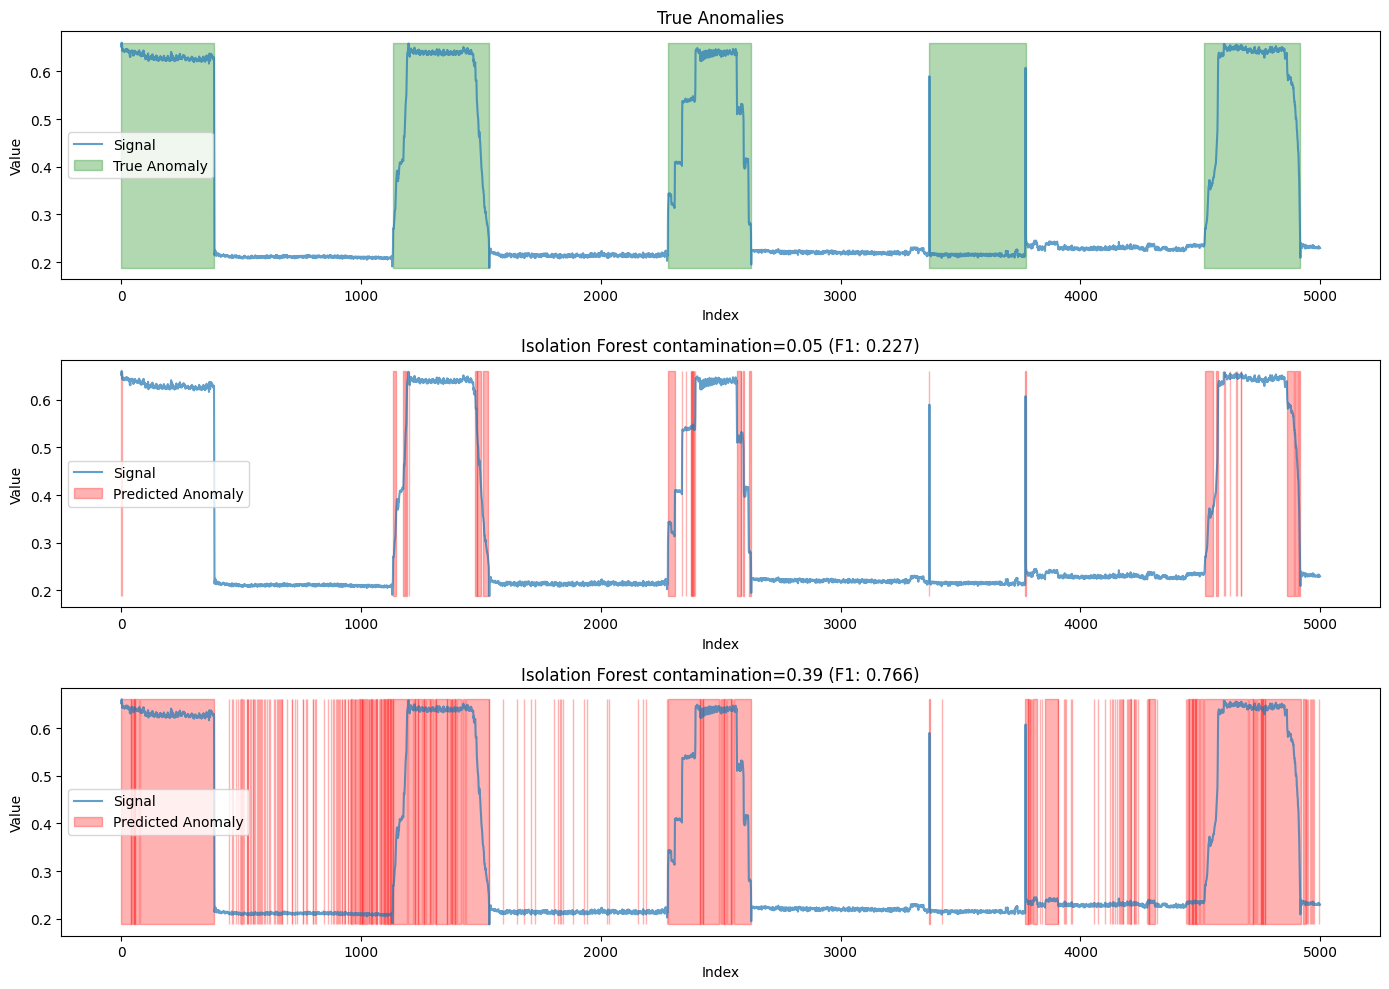

In [182]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report

# Reshape for sklearn
X = signal.reshape(-1, 1)

# True labels
y_true = data_sample["anomaly"].to_numpy()

# Isolation Forest with true contamination (39%)
iso_true = IsolationForest(contamination=y_true.mean(), random_state=42)
y_pred_iso_true = (iso_true.fit_predict(X) == -1).astype(int)

# Isolation Forest with default contamination (5%)
iso_default = IsolationForest(contamination=0.05, random_state=42)
y_pred_iso_default = (iso_default.fit_predict(X) == -1).astype(int)

# Scores


print("\n=== Isolation Forest (contamination=0.05) ===")
print(f"F1: {f1_score(y_true, y_pred_iso_default):.3f}")
print(classification_report(y_true, y_pred_iso_default, target_names=["Normal", "Anomaly"]))

print("=== Isolation Forest (contamination=0.39) ===")
print(f"F1: {f1_score(y_true, y_pred_iso_true):.3f}")
print(classification_report(y_true, y_pred_iso_true, target_names=["Normal", "Anomaly"]))


# Plot
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# True anomalies
axes[0].plot(signal, label="Signal", alpha=0.7)
axes[0].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_true==1, color='green', alpha=0.3, label="True Anomaly")
axes[0].set_title("True Anomalies")
axes[0].legend()
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")

# Isolation Forest (contamination=0.05)
axes[1].plot(signal, label="Signal", alpha=0.7)
axes[1].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_pred_iso_default==1, color='red', alpha=0.3, label="Predicted Anomaly")
axes[1].set_title(f"Isolation Forest contamination=0.05 (F1: {f1_score(y_true, y_pred_iso_default):.3f})")
axes[1].legend()
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")


# Isolation Forest (contamination=0.39)
axes[2].plot(signal, label="Signal", alpha=0.7)
axes[2].fill_between(range(len(signal)), signal.min(), signal.max(),
                     where=y_pred_iso_true==1, color='red', alpha=0.3, label="Predicted Anomaly")
axes[2].set_title(f"Isolation Forest contamination=0.39 (F1: {f1_score(y_true, y_pred_iso_true):.3f})")
axes[2].legend()
axes[2].set_xlabel("Index")
axes[2].set_ylabel("Value")


plt.tight_layout()
plt.show()

## 4. Comparison


In [183]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

# Comparison table
results = pd.DataFrame({
    "Model": [
        "Z-score Classic (t=3)", 
        "Z-score Classic (t=1)", 
        "Z-score Robust (t=3)", 
        "Isolation Forest (c=0.39)",
        "Isolation Forest (c=0.05)"
    ],
    "F1 Score": [
        f1_score(y_true, y_pred_classic_3),
        f1_score(y_true, y_pred_classic_1),
        f1_score(y_true, y_pred_robust),
        f1_score(y_true, y_pred_iso_true),
        f1_score(y_true, y_pred_iso_default)
    ],
    "Precision": [
        precision_score(y_true, y_pred_classic_3),
        precision_score(y_true, y_pred_classic_1),
        precision_score(y_true, y_pred_robust),
        precision_score(y_true, y_pred_iso_true),
        precision_score(y_true, y_pred_iso_default)
    ],
    "Recall": [
        recall_score(y_true, y_pred_classic_3),
        recall_score(y_true, y_pred_classic_1),
        recall_score(y_true, y_pred_robust),
        recall_score(y_true, y_pred_iso_true),
        recall_score(y_true, y_pred_iso_default)
    ]
})

results = results.sort_values("F1 Score", ascending=False)
print(results.to_string(index=False))

                    Model  F1 Score  Precision   Recall
     Z-score Robust (t=3)  0.880898   0.996745 0.789175
    Z-score Classic (t=1)  0.792159   0.999215 0.656186
Isolation Forest (c=0.39)  0.766254   0.767045 0.765464
Isolation Forest (c=0.05)  0.227397   0.996000 0.128351
    Z-score Classic (t=3)  0.000000   0.000000 0.000000


/home/mouna/Projects_data/sensordata_migration_prediction/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])




**Changepoint Detection:** PELT can be a good first approach, there is room for improvement here or maybe a call to use another method.  

**Anomaly Detection:** Robust Z-score achieves the best F1 score. Classic Z-score and Isolation Forest fails due to high anomaly ratio (39%).

### Why different thresholds?

**Classic Z-score (threshold=3):** 
- Standard threshold (99.7% rule)
- Fails here because anomalies = 39% of data
- Mean and std are polluted → anomalies look "normal"
- F1 ≈ 0

**Classic Z-score (threshold=1):**
- Lower threshold to compensate for polluted mean/std
- Found via grid search (data-driven)
- Better F1, but threshold is arbitrary

**Robust Z-score (threshold=3):**
- Standard threshold works because median/MAD ignore outliers
- No need to tune → more reliable
- Best F1, recommended for production

For production: Robust Z-score for anomaly flagging, PELT for identifying regime changes.

